### Step 1. Open the data file and study the general information. 

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats as st
import scipy.stats as stats
from scipy.stats import mannwhitneyu




In [2]:

call=pd.read_csv('datasets/pro3/megaline_calls.csv')
message=pd.read_csv('datasets/pro3/megaline_messages.csv')
internet=pd.read_csv('datasets/pro3/megaline_internet.csv')
plan=pd.read_csv('datasets/pro3/megaline_plans.csv')
user=pd.read_csv('datasets/pro3/megaline_users.csv')


In [3]:
call.head(2)


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66


In [4]:
message.head(2)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31


In [5]:
internet.head(2)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00


In [6]:
plan

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [7]:

user.head(2)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN


In [8]:
call.isnull().any().any(), message.isnull().any().any(), internet.isnull().any().any(), plan.isnull().any().any(), user.isna().any().any()

(False, False, False, False, True)

In [9]:
user.isna().mean().round(4) * 100

user_id        0.0
first_name     0.0
last_name      0.0
age            0.0
city           0.0
reg_date       0.0
plan           0.0
churn_date    93.2
dtype: float64

we have different data set about the customer's information and the prepaid plans that they use. I have to find out which of these plans brings more profit. I looked at the general view of each data set (head) the checked missing value. It is very good that there is no missing value(it is only good news for me today)except in churn_date but it means that the calling plan was still used. I think there is no way to fill these values.

We have here a little problem, internet usage and call duration  13% and 19 % are zero. Their problem is this could be real and not real. Because some people do not use mobile internet because of their old mobile phone or other reason. Therefore, I will look at who their people are and whether these are old, if these are old I will not replace them,( because most elder people do not use mobile internet) if these people are young, I have to fill these zeros with median I think. I looked at the data ( I wrote some code, then deleted them in order to not make the task more compilated but I just wanted to explain why I left the zeros) saw that zero usage exist all age group. Therefore I decide not to fill the o value with something. (  But zero calls I think it is quite possible. 

In [10]:
call.info(), message.info(),  internet.info(), plan.info(), user.info(),

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (tot

(None, None, None, None, None)

### Step 2. Prepare the data


In [11]:
call['call_date']=pd.to_datetime(call['call_date'], format='%Y-%m-%dT%H:%M:%S').dt.normalize()
message['message_date']=pd.to_datetime(message['message_date'], format='%Y-%m-%dT%H:%M:%S').dt.normalize()
internet['session_date']=pd.to_datetime(internet['session_date'], format='%Y-%m-%dT%H:%M:%S').dt.normalize()
user['reg_date']=pd.to_datetime(user['reg_date'], format='%Y-%m-%dT%H:%M:%S').dt.normalize()

In [12]:
call['month']=call['call_date'].dt.month_name() 
message['month']=message['message_date'].dt.month_name() 
internet['month']=internet['session_date'].dt.month_name() 

Then I created month columns in the call, message, and internet because I will need them to compare the monthly cost of customers

In [13]:
call['duration']=np.ceil(call['duration'])


I rounded the duration because the description of the plans says so.

In [14]:
sum_mb = internet.groupby(['user_id','month'])['mb_used'].sum()
count_call = call.groupby(['user_id','month'])['call_date'].count()
sum_minute=call.groupby(['user_id','month'])['duration'].sum()
count_message = message.groupby(['user_id','month'])['message_date'].count()

In [15]:
merged= pd.merge(left = sum_mb , 
                right = count_call, how='outer',on=["user_id","month" ]).fillna(0)
merged1= pd.merge(left = merged , 
                right = sum_minute, how='outer',on=['user_id', "month"  ]).fillna(0)
merged2= pd.merge(left = merged1 , 
                right = count_message, how='outer',on=['user_id',"month" ]).fillna(0)
merged3= pd.merge(left = merged2 , 
                right = user, how='outer',on=['user_id']).fillna(0)

In [16]:
merged2 = merged2.reset_index()
merged3= pd.merge(left = merged2 , 
                right = user, how='outer',on=['user_id']).fillna(0)

The reason is that sometimes missing values cause some problems due to the type while converting data type or making graphs. I think that 0 value is not dangerous( in this project ) for example when I use .sum() this case  0 has no effect or when I use count() this time 0 and missing value are the same because for of them are counted as 1. And here  the reason why  we have missing value  due to merging the data( I will type shape to prove that the number of row are different in data set), therefore We can  not fill them with anything, and I think in some cases 0 value is better than just letting missing value as 'nan'. 

In [17]:
sum_mb.shape, sum_minute.shape, count_message.shape, user.shape

((2277,), (2258,), (1806,), (500, 8))

In [18]:
merged3['mb_used']=np.ceil(merged3['mb_used']/1024)

In [19]:
merged3 = merged3.rename(columns={'mb_used': 'sum_gb','call_date': 'number_call', 'duration': 'sum_call_time', 'message_date': 'number_mesage' })


In [20]:
plan = plan.rename(columns={'plan_name': 'plan'})


I changed the name of some columns to make more accurate and easy to work with them

In [21]:
data= pd.merge(left = merged3 , 
                right = plan, how='outer',on=['plan']).fillna(0)

In [22]:
data['month'].value_counts()/len(data['month'])*100

December     20.364742
November     17.802866
October      14.893617
September    12.158055
August       10.117238
July          7.815892
June          6.252714
May           4.602692
April         3.082935
March         1.519757
February      0.694746
0             0.434216
January       0.260530
Name: month, dtype: float64

In [23]:
data[data['month']==0].head(2)

,user_id,month,sum_gb,number_call,sum_call_time,number_mesage,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
720,1025,0,0.0,0.0,0.0,0.0,Jess,Wilkinson,64,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-10-28,ultimate,0,1000,30720,3000,70,7,0.01,0.01
721,1269,0,0.0,0.0,0.0,0.0,Irving,Thompson,39,"Dallas-Fort Worth-Arlington, TX MSA",2018-09-13,ultimate,2018-12-15,1000,30720,3000,70,7,0.01,0.01


O(zero) value in month column does not seem so good, I looked at why there is zero value in a month then I saw that these customers did use their mobile service, and 0 values percentages in data is not much, Therefore, I decided to not to delete them. But I do not know exactly whether it was a good decision.

In [24]:
data_surf=data[data['plan']=='surf']
data_ultimate=data[data['plan']=='ultimate']

In [25]:
def total_cost(row):
    sum_call_time = row['sum_call_time']
    number_mesage = row['number_mesage']
    sum_gb = row['sum_gb']
    plan_name = row['plan']
    
    
    
    
    plan_cost = 0
    call_cost = 0
    message_cost = 0
    data_cost = 0
 
    if plan_name == 'surf':
        plan_cost = 20
        if sum_call_time <= 500:
            call_cost = 0
        else:
            call_cost = 0.03*(sum_call_time - 500)
 
        if number_mesage <= 50:
            message_cost = 0
        else:
            message_cost = 0.03*(number_mesage - 50)
 
        if sum_gb <= 15:
            data_cost = 0
        else:
            data_cost = 10*(sum_gb - 15)
    elif plan_name == 'ultimate':
        plan_cost = 70
        if sum_call_time <= 3000:
            call_cost = 0
        else:
            call_cost = 0.01*(sum_call_time - 500)
 
        if number_mesage <= 1000:
            message_cost = 0
        else:
            message_cost = 0.01*(number_mesage - 50)
 
        if sum_gb <= 30:
            data_cost = 0
        else:
            data_cost = 7*(sum_gb - 30) 
    monthly_income = plan_cost + call_cost + message_cost + data_cost
    return monthly_income


In [26]:
data['monthly_income']=data.apply(total_cost,axis=1)


I tried here to create monthly income for a company or you can call it monthly cost for customers. I know that it would be better if I would refer directly to data for "1 minute: 3 cents
1 text message: 3 cents" but I saw that it getting more compilated therefore I used just 0.03, 0.01 and so numbers for costs.

I converted certain data to necessary types then applied the prepaid plans according to their tariff. (Namely,  surf, and Ultimate prepaid plans)  .In order to compare the monthly income of each prepaid plan, I created monthly columns for internet(roundly monthly usage), call (rounded daily usage to minutes then calculated monthly usage), and message. The purpose of that to see the difference between these prepaid users. To find the cost of easy users I used the information in the plan data set. For this purpose, I used the total cost function and applied it to monthly income columns. Now, we can see easily the money cost of the easy users. The in the next task I will try to numerically and graphically find which prepaid brings more revenue


### Step 3. Analyze the data


In [27]:
pivot_surf=data.query('plan == "surf"').pivot_table(index='month', values='monthly_income', aggfunc='median')
pivot_ultimate=data.query('plan == "ultimate"').pivot_table(index='month', values='monthly_income', aggfunc='mean')


Text(0, 0.5, 'Monthly Income')

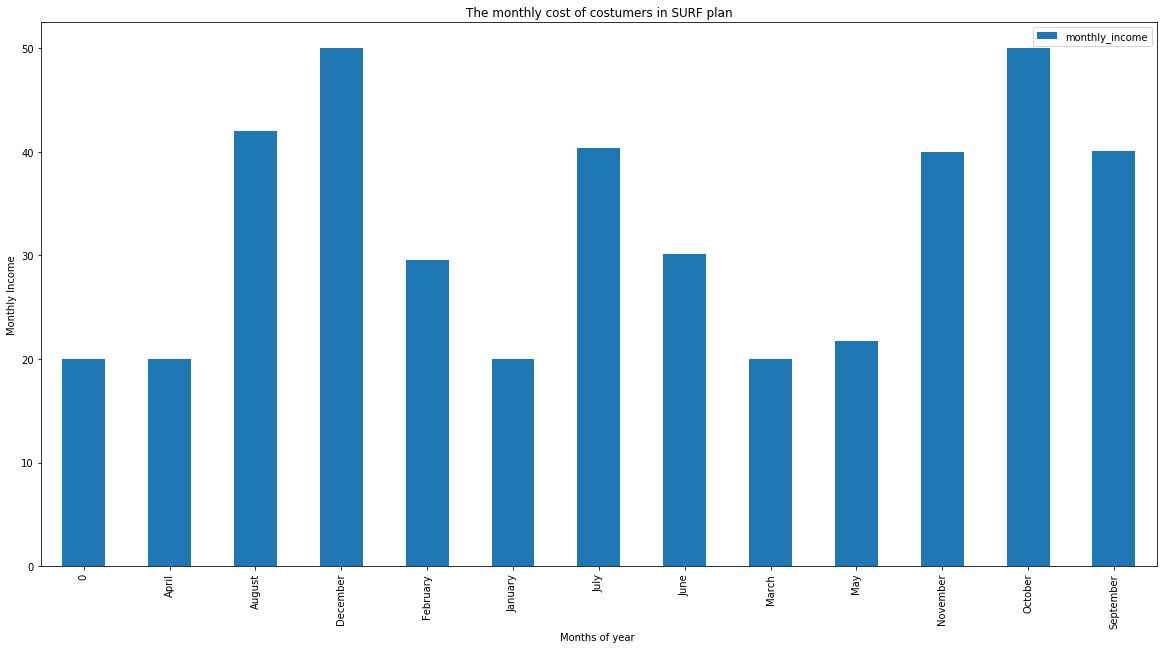

In [28]:
surf_bar=pivot_surf.plot(kind='bar', figsize=(20,10))
surf_bar.set_title("The monthly cost of costumers in SURF plan")
plt.xlabel('Months of year ')
plt.ylabel("Monthly Income")

I thought that it is also necessary to see in which month the company earn more. For example, in January consumers used the least and in December the most mobile services.

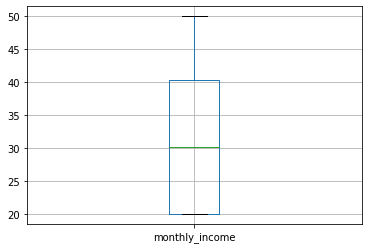

In [29]:
pivot_surf.boxplot()
plt.show()

In [30]:
Q1 = pivot_surf['monthly_income'].quantile(0.25)
Q3 = pivot_surf['monthly_income'].quantile(0.75)
print("First quartile of car monthly is ", Q1)
print("First quartile of car monthly is ", Q3)

First quartile of car monthly is  20.0
First quartile of car monthly is  40.33


Q1 and Q3 values are between 40 and 62. I would say that sufr plan seems to be profitable because if you compare it to 20 dollars we can see that most of the consumers use much more than the monthly

Text(0, 0.5, 'Monthly Income')

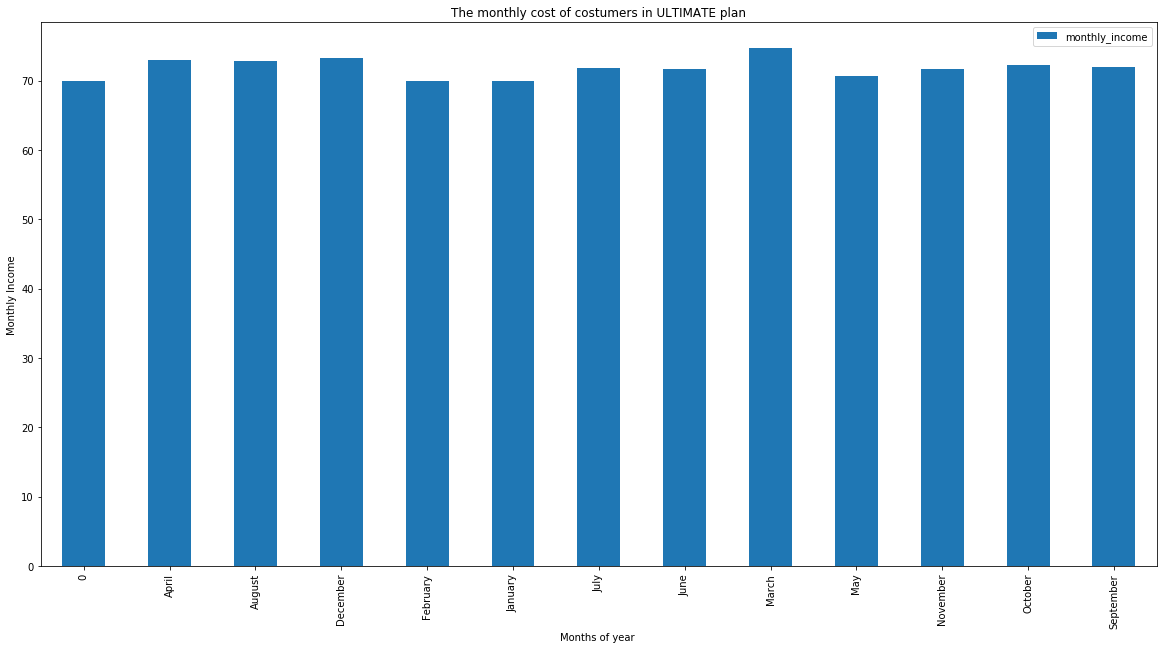

In [31]:
ultimate_bar=pivot_ultimate.plot(kind='bar', figsize=(20,10))
ultimate_bar.set_title("The monthly cost of costumers in ULTIMATE plan")
plt.xlabel('Months of year ')
plt.ylabel("Monthly Income")

The graph shows that the monthly cost is almost the same around 70 in all months in fact we have seen the same thing in Q1 and Q3 values I mean can say that by looking these values, but this time in a graph form.  

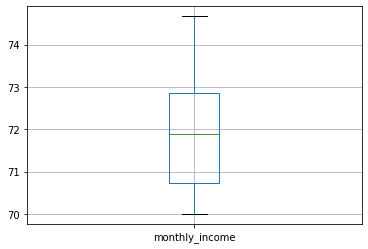

In [32]:
pivot_ultimate.boxplot()
plt.show()

In [33]:
Q1 = pivot_ultimate['monthly_income'].quantile(0.25)
Q3 = pivot_ultimate['monthly_income'].quantile(0.75)
print("First quartile of car monthly is ", Q1)
print("First quartile of car monthly is ", Q3)

First quartile of car monthly is  70.72413793103448
First quartile of car monthly is  72.85915492957747


Ultimate plan but shows quite different scenarios, people do not use more than almost month limits. Q1 and Q3 values are between 70 and 72 and the mean value is 70.

In [34]:
data.groupby('plan')['monthly_income'].sum()

plan
surf        95611.18
ultimate    52346.00
Name: monthly_income, dtype: float64

In [35]:
data.groupby('plan')['monthly_income'].median()

plan
surf        40.18
ultimate    70.00
Name: monthly_income, dtype: float64

In [36]:
data_surf1=data.query('plan == "surf"').pivot_table(index='user_id', values='monthly_income', aggfunc='mean')
data_ultimate1=data.query('plan == "ultimate"').pivot_table(index='user_id', values='monthly_income',aggfunc='mean' )
data_surf2=data[data["plan"]=="surf"]
data_ultimate2=data[data["plan"]=="ultimate"]
data_NY=data[data['city'].str.contains("NY-NJ")]
data_NanNY=data[~data['city'].str.contains("NY-NJ")]


I thought It will be better to look at the sum and median for the last time to make decisions about which plan is better. For revenue prospects it clear that sufr plan is better than the ultimate plan.

In [37]:
customer_behavior=data.pivot_table(index=['plan','month'], values=['sum_gb', 'number_call', 'sum_call_time','number_mesage'], aggfunc=('mean','median')).round(2)
customer_behavior

number_call        number_mesage        sum_call_time  \
                          mean median          mean median          mean   
plan     month                                                             
surf     0                0.00    0.0          0.00    0.0          0.00   
         April           48.88   47.0         17.40   10.0        351.54   
         August          57.56   55.5         28.78   20.0        410.11   
         December        65.45   64.5         38.60   31.0        473.84   
         February        40.67   37.0         12.00    3.0        297.00   
         January         30.00   30.0         10.50   10.5        203.00   
         July            63.16   65.0         27.03   20.0        449.98   
         June            59.47   61.0         25.30   15.0        431.30   
         March           46.43   49.0         15.26    7.0        330.00   
         May             55.70   58.0         24.01   15.0        399.58   
         November        59.12   58.0         32.39   27.0        423.33   
         October         60.35   61.0         33.84   26.0        429.73   
         September       58.11   59.0         30.76   22.5        414.23   
ultimate 0                0.00    0.0          0.00    0.0          0.00   
         April           47.52   49.0         22.05   17.0        336.86   
         August          60.07   60.0         38.48   36.0        421.44   
         December        64.90   62.0         45.01   41.0        459.10   
         February        58.29   63.0         21.57   15.0        403.14   
         January         28.00   32.5         15.50   12.5        193.50   
         July            58.69   62.0         32.83   28.0        427.07   
         June            52.17   57.0         29.34   21.0        370.96   
         March           46.00   36.0         20.25   12.0        304.25   
         May             57.59   58.0         32.10   19.0        406.24   
         November        62.36   63.0         38.61   32.0        445.20   
         October         63.78   67.0         39.44   35.0        450.74   
         September       61.05   61.0         37.90   31.5        437.51   

                          sum_gb         
                   median   mean median  
plan     month                           
surf     0            0.0   0.00    0.0  
         April      339.5  12.22   12.0  
         August     392.0  16.88   17.0  
         December   449.0  18.24   18.0  
         February   254.0  12.22   12.0  
         January    203.0   5.00    5.0  
         July       454.0  16.88   17.0  
         June       423.0  15.48   16.0  
         March      334.0  13.57   14.0  
         May        415.0  14.12   14.0  
         November   413.0  16.43   17.0  
         October    432.0  17.41   18.0  
         September  426.0  16.69   17.0  
ultimate 0            0.0   0.00    0.0  
         April      301.0  16.33   16.0  
         August     406.0  17.85   18.0  
         December   436.0  18.40   17.0  
         February   428.0  17.29   20.0  
         January    234.0   7.25    8.0  
         July       430.0  16.49   15.0  
         June       399.0  15.43   15.0  
         March      251.0  18.42   21.0  
         May        407.0  16.86   17.0  
         November   432.0  17.12   17.0  
         October    460.5  17.72   17.0  
         September  434.0  17.01   16.5

In [38]:
str_surf=data_surf2[['sum_gb','number_call', 'sum_call_time','number_mesage']]
str_ultimate=data_ultimate2[['sum_gb','number_call', 'sum_call_time','number_mesage']]


In [39]:
str_surf.shape

(1579, 4)

In [40]:
standard_deviation=str_surf.std(axis = 0) 
standard_deviation

sum_gb             7.899502
number_call       32.168377
sum_call_time    235.490079
number_mesage     33.557683
dtype: float64

In [41]:
str_ultimate.shape

(724, 4)

In [42]:
standard_deviation=str_ultimate.std(axis = 0) 
standard_deviation

sum_gb             7.755841
number_call       33.454527
sum_call_time    241.958423
number_mesage     34.782576
dtype: float64

In [43]:
variance = np.var(str_surf)
print(variance)


sum_gb              62.362606
number_call       1034.149122
sum_call_time    55420.456705
number_mesage     1125.404892
dtype: float64


In [44]:
variance = np.var(str_ultimate)
print(variance)

sum_gb              60.069982
number_call       1117.659540
sum_call_time    58463.016941
number_mesage     1208.156579
dtype: float64


I thought that it would be better to look at the var and standard deviation separately ( according to plan ). Standard deviation and naturally variance values are higher if we compare mean and median it means that this it, not a normal distribution . But it is better to look at the hist graph to be sure.

Text(0.5, 0, 'monthly income')

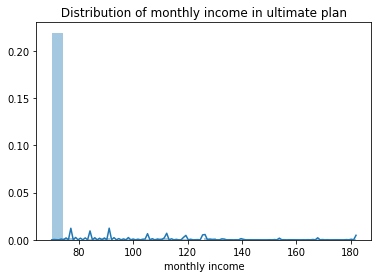

In [45]:
ab=sns.distplot(data_ultimate2['monthly_income']) 
ab.set_title(" Distribution of monthly income in ultimate plan ")
ab.set_xlabel('monthly income')

Text(0.5, 0, 'monthly income')

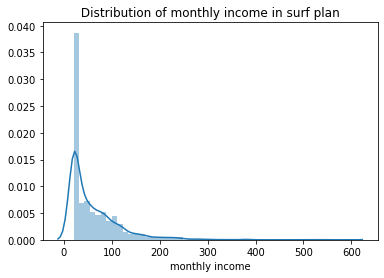

In [46]:
ax=sns.distplot(data_surf2['monthly_income']) 
ax.set_title(" Distribution of monthly income in surf plan ")
ax.set_xlabel('monthly income')

The graph again proved that this data is not a normal distribution.

In [47]:
data.groupby('plan')['monthly_income'].sum()


plan
surf        95611.18
ultimate    52346.00
Name: monthly_income, dtype: float64

Text(0.5, 0, 'Sum of internet usage')

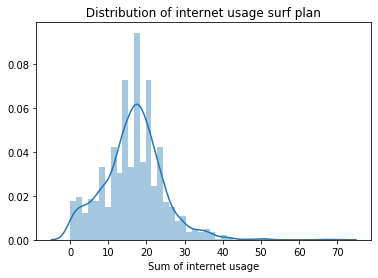

In [48]:
surf_internet=sns.distplot(data_surf2['sum_gb']) 
surf_internet.set_title(" Distribution of internet usage surf plan ")
surf_internet.set_xlabel('Sum of internet usage')

In [49]:
data_surf2['sum_gb'].describe()

count    1579.000000
mean       16.607346
std         7.899502
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: sum_gb, dtype: float64

The graph is normally distributed, most internet users use 16 Gb  which is the mean. ( I typed describe to see exactly the mean, by the way, I think we do not need boxplot, Q1 and Q2 values, describe shows everything . )

Text(0.5, 0, 'Number of made call')

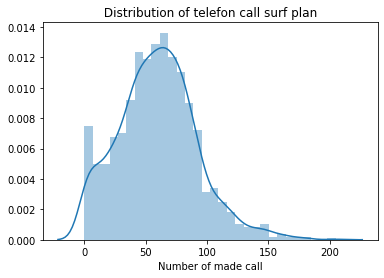

In [50]:
surf_call_number=sns.distplot(data_surf2['number_call'])  
surf_call_number.set_title(" Distribution of telefon call surf plan ")
surf_call_number.set_xlabel('Number of made call')

The number of made call is also distributed, the mostly people made something 70 call per month 

Text(0.5, 0, 'Sum of made duration ')

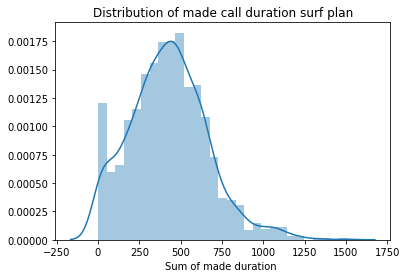

In [51]:
surf_call_duation=sns.distplot(data_surf2['sum_call_time']) 
surf_call_duation.set_title("Distribution of made call duration surf plan")
surf_call_duation.set_xlabel('Sum of made duration ')

Text(0.5, 0, 'Sum of internet usage')

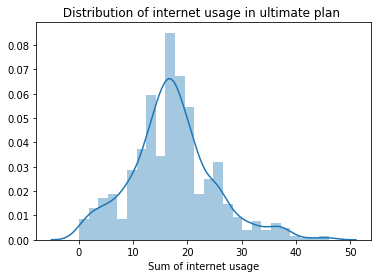

In [52]:
ultimate_internet=sns.distplot(data_ultimate2['sum_gb']) 
ultimate_internet.set_title(" Distribution of internet usage in ultimate plan  ")
ultimate_internet.set_xlabel('Sum of internet usage')

Text(0.5, 0, 'Number of made call')

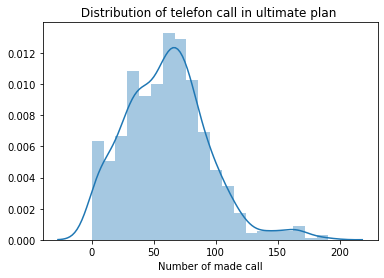

In [53]:
ultimate_call_number=sns.distplot(data_ultimate2['number_call']) 
ultimate_call_number.set_title(" Distribution of telefon call in ultimate plan  ")
ultimate_call_number.set_xlabel('Number of made call')

Text(0.5, 17.200000000000003, 'Sum of made duration')

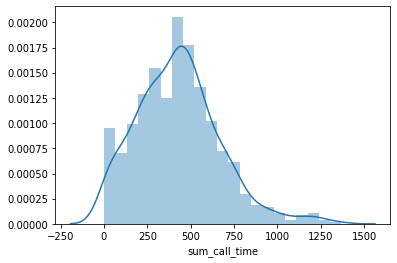

In [54]:
ultimate_call_duation=sns.distplot(data_ultimate2['sum_call_time']) 
ultimate_call_number.set_title(" Distribution of made call duration ultimate plan")
ultimate_call_number.set_xlabel('Sum of made duration')

Except for the monthly cost, others are normally distributed, it means that most of the data is around mean. I can say it generally for all of them. 

Suft plan is more profitable that ultimate 

The main purpose of the step is to find out which prepaid( suft and ultimate) brings more revenue to the company. To find it used their revenue monthly for each prepaid plan, boxplot, and distplot to see the data distribution. So, the data was not normally distributed and they are right-skewed.  Sufr plan has more fluctuation in monthly cost , Q1 and Q2 values are between 20 and 40 but ultimate plans  Q1 and Q2 are between 70 and 72. We can also see the mean and median of both prepaid plans to analyze the behavior of customer. We see that again difference mean and median in suft plan is larger in comparison with the ultimate plan. We can also look at standard deviation to see data distribution , they have about 7 std but surf data set has more data than ultimate. See can see which suft brings more revenue by looking at just sum of the monthly income of each prepaid plan, and suft is almost brought 2 times more revenue than the ultimate plan.  As a conclusion , the company should focus on sufs plan adds

### Step 4. Test the hypotheses



I used  Mann-Whitney U test 

The first hypothesis is that "The average revenue from users of Ultimate and Surf calling plans differs."". I take H 0 as the Average revenue is the same in both prepaid plans. H1 as The average revenue from users of Ultimate and Surf calling plans differs. I order to find answers to these questions we have to look at the monthly income of both plans the find means, and the probability that both have the same value, if the p-value is less than 0.05 we reject H0 otherwise we will accept H0. The distribution of monthly income is nonparametric therefore, I used Mann Whitney U test. 

I am sorry I do not understand the question exactly, but I think you mentioned that  why I chose 'the Average revenue is the same in both prepaid plans' as H0 but in the task  " The average revenue from users of Ultimate and Surf calling plans differ." are given as the hypotheses or H0. But I think that it is better to choose 'remain the same or they are equal ' as H0 is better. That is why I set H0 like this. 

In [55]:
stat, p = mannwhitneyu(data_ultimate2['monthly_income'], data_surf2['monthly_income'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print("We can't reject the null hypothesis")
else:
	print("We reject the null hypothesis")

Statistics=357118.000, p=0.000
We reject the null hypothesis


The reason is that monthly income is not distributed normall
y, that is why to used Mann-Whitney.

The null hypothesis is that there is not the difference between plans in terms of average revenue. But we see that the p-value is almost 0, and it means that the means of the two plans are located very far distance from each other. We reject the null hypothesis

In [56]:
data_NY=data[data['city'].str.contains("NY-NJ")]
data_NanNY=data[~data['city'].str.contains("NY-NJ")]


The second hypothesis is that "The average revenue from users in NY-NJ area is different from that of the users from other regions"". H0 is Average revenue is the same all-region, but H1 is that NY-NJ differs from others. 

In [57]:
stat, p = mannwhitneyu(data_NY['monthly_income'], data_NanNY['monthly_income'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print("We can't reject the null hypothesis")
else:
	print("We reject the null hypothesis")

Statistics=331433.500, p=0.003
We reject the null hypothesis


The null hypothesis is The average revenue from users in NY-NJ area is the not same  with that of the users from other regions.Again p value is less than 0.05 . THerefore , we refect H0 and accept H1 

You re absolutly  right, The average revenue from users in NY-NJ area is the  not same  with   that of the users from other regions 

So, We have 2 hypotheses here to improve company strategy and find out where or which group company should focus on in order to get more profit. Our first hypnosis says that suft plan and ultimate plan differ in terms of average revenue, and there are not significant profit differences in regions. 

### Step 5. Write an overall conclusion


The data was about two prepaid plans, Surf and Ultimate of telecom operator Megaline. After analyzing we can see that Surf plan brings more profit than the Ultimate prepaid plan. The income in Sufr fluctuated in the month of years but Ultimate almost stay the same in all months of the year. Most of Surf user exit their limits but it does not the case in the Ultimate plan. The monthly payment is Nonparametric in Sufr and Ultimate plan, the result of Mann-Whitney U test, the average payment of Surf and Ultimate different significantly and The average revenue from users in NY-NJ area is different from that of the users from other regions. 

There are several data set about the usage of mobile internet users. The main purpose is to find out which prepaid plan is profitable,  I added monthly cost and monthly usage of the message, call, in internet usage to compare them in two plans.  Then I used distplot to show the distribution of the data.  The 0 usage of internet usage and 0 calls are abnormal, but I think somehow we can justify that with different reasons, except for the monthly cost,  the data are almost normally distributed. I think the reason why monthly  cost why not normally distributed  is because of the monthly set fee. So I as an clumsy  data analyst, I can say that the firm shoud spend more money on ad of Surf plan. :)
